### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [1]:
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

### 1. Reading data

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content with data cleaning
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [53]:
T0 = np.array(data[2], dtype = str)
ra = np.array(data[3], dtype= float)
decl = np.array(data[4], dtype = float)
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9], dtype = float)
redshift = np.array(data[11], dtype = float)
T100 = np.array(data[12], dtype = float)
condition = (T90 != -999) 
T90 = T90#[condition]
log10T90 = np.log10(T90[condition])

### 2. Data Exploration 

Studying the dataset, it is possible to observe a bimodal distribution in the T90 variable.

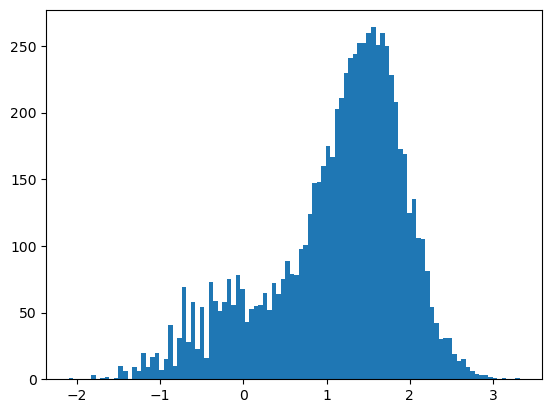

In [5]:
plt.hist(log10T90, bins = 100)
plt.show()

### 3.0 Kernel Density Estimator

First, I try to analyze this bimodal distribution with a kernel density estimator. Initially, I select the optimal bandwith with cross-validation.

In [6]:
#Execute this cell to determine the bandwidth
bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
K = 2 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(log10T90[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.13692307692307693


Then, I use it to fit the data with the corresponding KDE.

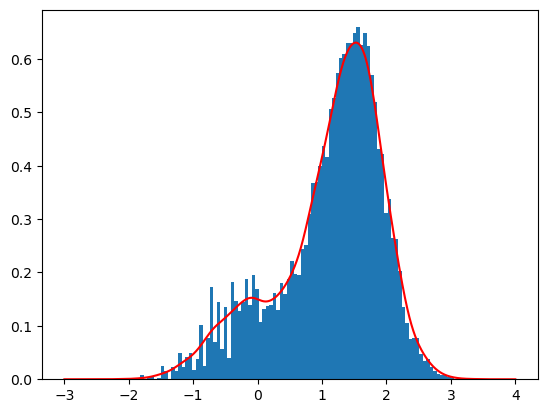

In [7]:
def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

xgrid = np.linspace(-3,4,len(log10T90))
pdf = kde_sklearn(log10T90,bandwidth=h_opt)
plt.plot(xgrid,pdf,c='red')
plt.hist(log10T90, bins = 100, density = True);

From this method I obtain the following centers for the clusters.

In [8]:
clf = KMeans(n_clusters = 2, n_init = 10)
clf.fit(log10T90[:, None])

KMeans(n_clusters=2, n_init=10)

In [9]:
clf.cluster_centers_

array([[ 1.52244118],
       [-0.03985797]])

Here, I visualize the two centers and the obtained pdf on the histogram. 

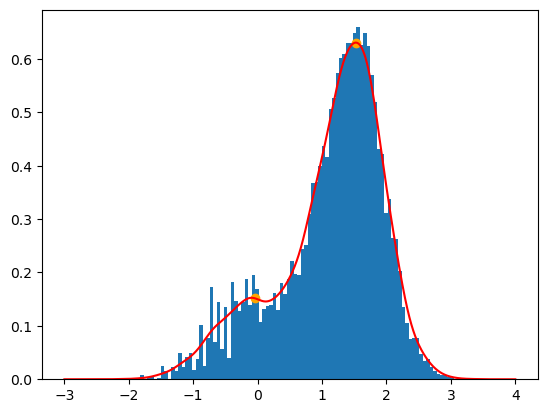

In [10]:
plt.plot(xgrid,pdf,c='red')
counts, edges, bars = plt.hist(log10T90, bins = 100, density = True)
plt.scatter(clf.cluster_centers_[0], pdf[np.argmin(np.abs(clf.cluster_centers_[0]-xgrid))], color = 'orange')
plt.scatter(clf.cluster_centers_[1], pdf[np.argmin(np.abs(clf.cluster_centers_[1]-xgrid))], color = 'orange');

### 4.0 Gaussian Mixture Components

Then, I repeat the process with a Gaussian Mixture. Firstly, I compute the corresponding AIC of different number of gaussians for the mixture, to obtain the optimal number of gaussians.

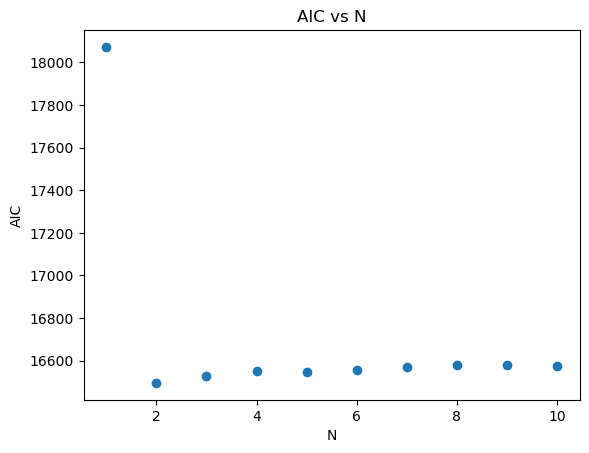

In [11]:
N = [1,2,3,4,5,6,7,8,9,10]
AIC = []
for i in N:
    gm = GaussianMixture(n_components=i, random_state=0).fit(log10T90[:, None])
    #fig = plt.figure()
    #plt.hist(dati, bins = 50, density = True)
    #plt.plot(a, np.exp(gm.score_samples(a[:,np.newaxis])))
    AIC.append(gm.aic(log10T90[:,None]))
    i = i+1

plt.scatter(N, AIC)
plt.xlabel('N')
plt.ylabel('AIC')
plt.title('AIC vs N')
plt.show()

Since the minimum AIC corresponds to a number of gaussian equal to 2, I fit the data with a gaussian mixture with 2 components, and I compare it with the data histogram.

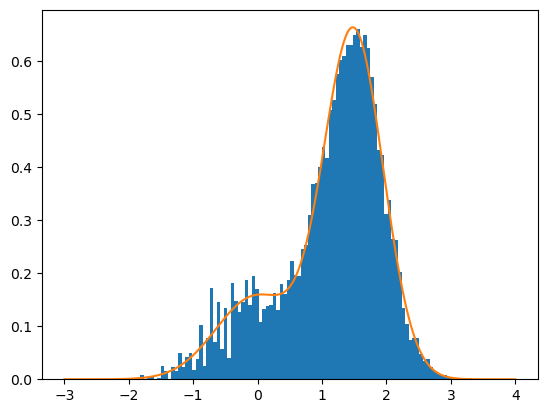

In [12]:
gm = GaussianMixture(n_components=2, random_state=0).fit(log10T90[:, None])
plt.hist(log10T90, bins = 100, density = True)
plt.plot(xgrid, np.exp(gm.score_samples(xgrid[:,np.newaxis])))
#plt.xlabel(r'$\mathcal{M}_c$ $[M_\odot]$')
#plt.ylabel(r'$p(\theta)$')
plt.show()

### 5.0 Comparison of the two Methods

Firstly, I compare the cluster centers from each method.

In [22]:
print('First cluster center computed with Kmeans, Gaussian Mixture: ', gm.means_[1], clf.cluster_centers_[1])
print('Second cluster center computed with Kmeans, Gaussian Mixture and difference: ', gm.means_[0], clf.cluster_centers_[0])

First cluster center computed with Kmeans, Gaussian Mixture:  [-0.03099617] [-0.03985797]
Second cluster center computed with Kmeans, Gaussian Mixture and difference:  [1.48659576] [1.52244118]


In [23]:
print('First cluster center difference: ',  np.abs(gm.means_[0]-clf.cluster_centers_[0]))
print('Second cluster center difference: ',  np.abs(gm.means_[1]-clf.cluster_centers_[1]))

First cluster center difference:  [0.03584542]
Second cluster center difference:  [0.0088618]


Then, I plot them on the histogram.

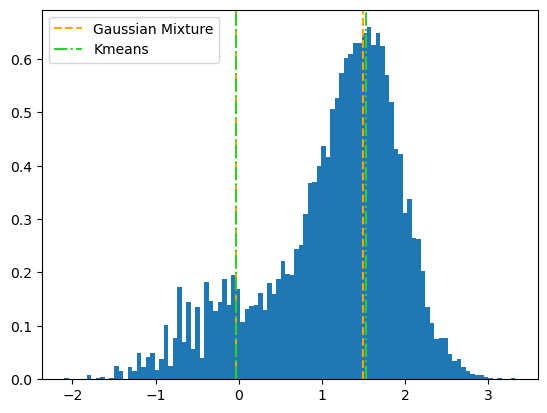

In [15]:
plt.hist(log10T90, density = True, bins = 100)
plt.axvline(gm.means_[0], linestyle = '--', color = 'orange', label = 'Gaussian Mixture')
plt.axvline(gm.means_[1], linestyle = '--', color = 'orange')
plt.axvline(clf.cluster_centers_[1], linestyle = '-.', color = 'limegreen', label = 'Kmeans')
plt.axvline(clf.cluster_centers_[0], linestyle = '-.', color = 'limegreen')
plt.legend();

Here, I compare their predictions with a confusion matrix.

In [25]:
prediction = gm.predict(log10T90[:, None])
confusion_matrix(prediction,clf.predict(log10T90[:, None]))

array([[5490,  285],
       [   0, 1615]], dtype=int64)

Here, we can see that the confusion matrix has some terms off the diagonal. This is due to the fact that the Kernel Density Estimator separates the two cluster in a sharp way, while Gaussian Mixture is able to consider the single pdfs and therefore consider the points on the right wings of the long GRB distribution.

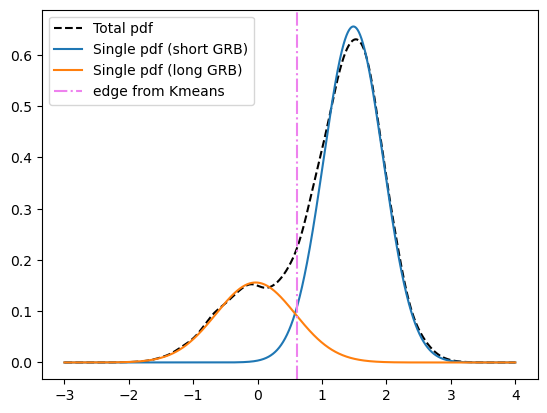

In [17]:
responsabilities = gm.predict_proba(xgrid[:, None])
single_pdfs = responsabilities*np.exp(gm.score_samples(xgrid[:, None]))[:, None]
edge = (np.mean( [max(log10T90[:, None][clf.predict(log10T90[:, None])==0]), min(log10T90[:, None][clf.predict(log10T90[:, None])==1]) ]))

plt.plot(xgrid, pdf, linestyle = '--', color = 'black', label = 'Total pdf')
plt.plot(xgrid, single_pdfs[:, 0], label = 'Single pdf (short GRB)')
plt.plot(xgrid, single_pdfs[:, 1], label = 'Single pdf (long GRB)')
plt.axvline(edge, color = 'violet', linestyle = '-.', label = 'edge from Kmeans')
plt.legend();